# Kinetic and canonic momentum comparison

### Simulation parameters

In [8]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 1         
# N = 64
N = 512
tau_sim = 0.06  
DTS = 16
# DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS

# Glasma fields
su_group = 'su3'
uv = 10.0
ir = 0.2
g2mu = 1.5

g = 2         		
mu = g2mu / g**2

ns = 50      

nevents = 1
quark = 'jet' # 'jet' or 'static'            

### Enviroment variables

In [9]:
import os

# os.environ["MY_NUMBA_TARGET"] = "numba"
# import warnings
# from numba.core.errors import NumbaPerformanceWarning, NumbaWarning
# warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)
# warnings.filterwarnings("ignore", category=NumbaWarning)

# Comment this, I need it for JYU GPUs to choose a specific GPU to run on
os.environ["CUDA_VISIBLE_DEVICES"]="5"
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Qhat module
if quark=='jet':
    import curraun.qhat_qeik as qeik
    # import curraun.qhat_qeik_old as qeik
elif quark=='static':
    import curraun.kappa_qeik as qeik

from tqdm import tqdm

In [10]:
def simulate_qhat(ev): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    # TODO: remove after
    mv.set_seed(314)
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Qhat module
    qeik_tforce = qeik.KineticCanonicCheck(s)  
    xplus = []
    dpcan_sq, dpkin_sq, da_sq = [], [], []
    da_transp_sq, dpcanda, dpcanda_transp = [], [], []
    intfa, da = [], []

    if use_cuda:
        s.copy_to_device()
        qeik_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            qeik_tforce.compute()
            
            if t % DTS == 0:
                
                if use_cuda:
                    qeik_tforce.copy_to_host()

                # Units GeV^2
                dpcan_sq.append(qeik_tforce.dpcan_sq_mean * E0 ** 2)
                dpkin_sq.append(qeik_tforce.dpkin_sq_mean * E0 ** 2)
                da_sq.append(qeik_tforce.da_sq_mean * E0 ** 2)
                da_transp_sq.append(qeik_tforce.da_transp_sq_mean * E0 ** 2)
                dpcanda.append(qeik_tforce.dpcanda_mean * E0 ** 2)
                dpcanda_transp.append(qeik_tforce.dpcanda_transp_mean * E0 ** 2)
                # Units GeV^-1
                xplus.append(2*t*a/DTS/hbarc)

                # No units
                intfa_sim = qeik_tforce.intfa.copy()
                intfa.append(intfa_sim[:, :, :])
                da_sim = qeik_tforce.da.copy()
                da.append(da_sim[:, :, :])

                if use_cuda:
                    qeik_tforce.copy_to_device()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)
    
    if use_cuda:
        cuda.current_context().deallocations.clear()

    return xplus, dpcan_sq, dpkin_sq, da_sq, da_transp_sq, dpcanda, dpcanda_transp, np.array(intfa), np.array(da)

In [11]:
collect_dpcan_sq, collect_dpkin_sq, collect_da_sq, collect_da_transp_sq, collect_dpcanda, collect_dpcanda_transp = [], [], [], [], [], []

for ev in range(nevents):
    xplus, dpcan_sq_ev, dpkin_sq_ev, da_sq_ev, da_transp_sq_ev, dpcanda_ev, dpcanda_transp_ev, intfa, da = simulate_qhat(ev)
   
    collect_dpcan_sq.append(dpcan_sq_ev)
    collect_dpkin_sq.append(dpkin_sq_ev)
    collect_da_sq.append(da_sq_ev)
    collect_da_transp_sq.append(da_transp_sq_ev)
    collect_dpcanda.append(dpcanda_ev)
    collect_dpcanda_transp.append(dpcanda_transp_ev)

dpcan_sq = np.mean(collect_dpcan_sq, axis=0)
dpkin_sq = np.mean(collect_dpkin_sq, axis=0)
da_sq = np.mean(collect_da_sq, axis=0)
da_transp_sq = np.mean(collect_da_transp_sq, axis=0)
dpcanda = np.mean(collect_dpcanda, axis=0)
dpcanda_transp = np.mean(collect_dpcanda_transp, axis=0) 

Event 1: 100%|██████████| 491/491 [12:28<00:00,  1.52s/it]


---
# Numerical checks
Compare the time-integrated Lorentz force that contribues to the gauge field, and the relative difference containing the parallel transported gauge field

$$\int_{\tau_0}^\tau \mathrm{d}\tau^\prime \tilde{f}^A_i(\tau^\prime)=\tilde{A}_i(\tau)-A_i(\tau_0)$$

where $\tilde{f}_i(\tau)=U(\tau,\tau_0)f_i U^\dagger(\tau,\tau_0)$ rotated with the Wilson line along the eikonal jet trajectory, and similarly for $\tilde{A}_i$. The Lorentz force contains
\begin{equation*}f_i^A=f_i^{p,\mathrm{can}}-f_i^{p,\mathrm{kin}}\end{equation*}
with the relevant components 
\begin{equation*}f_y^{p,\mathrm{can}}=-\partial_yA_x= -B_z^\mathrm{can},\quad f_z^{p,\mathrm{can}}=-\dfrac{1}{\tau^2} A_\eta = E_z^\mathrm{can}\end{equation*}
along with 
\begin{equation*}f_y^{p,\mathrm{kin}}=\dfrac{1}{\tau} P^y+F_{xy}= E_y^\mathrm{kin}-B_z^\mathrm{kin},\quad f_z^{p,\mathrm{kin}}=P^\eta+\dfrac{1}{\tau} D_xA_\eta=E_z^\mathrm{kin}+B_y^\mathrm{kin}\end{equation*}

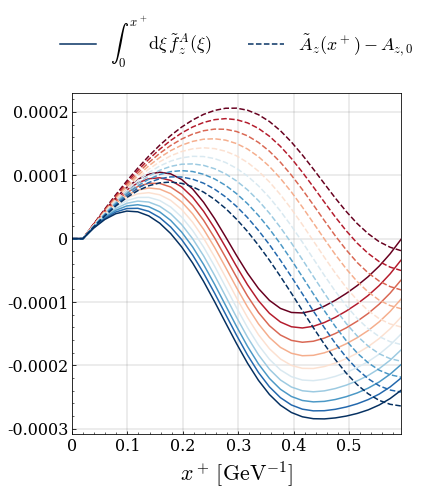

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import numpy as np  

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 7))

plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ntraj = 10

cmap_rb = mpl.cm.get_cmap('RdBu', 20)
colors = [cmap_rb(i) for i in np.linspace(0, 1, ntraj)]

i = 2
na = 8
for j in range(ntraj):
    plt.plot(xplus, da[:, j, i, na].imag, linewidth=1.5, linestyle='--', color=colors[j])
    plt.plot(xplus, intfa[:, j, i, na].imag, linewidth=1.5, color=colors[j])

plt.xlim([0, max(xplus)])
# plt.ylim([0, 0.0004])
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.xlabel(r"$x^+\,\mathrm{[GeV^{-1}]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color=colors[ntraj-1], lw=1.5, linestyle='-', label=r'$\int_0^{x^+}\mathrm{d}\xi\,\tilde{f}_z^A(\xi)$'),
    Line2D([0], [0], color=colors[ntraj-1], lw=1.5, linestyle='--', label=r'$\tilde{A}_z(x^+)-A_{z,0}$'),
]
    
legend = plt.legend(handles=legend_elements, fontsize=18, frameon=False, ncol=2, loc='lower center', bbox_to_anchor=(0.5, 1.02), title_fontsize=20)

# plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.tight_layout()
# plt.savefig('intfa_deltaa_z_static_n_' + str(N) + '.png', facecolor='w', dpi=600) 
plt.show()


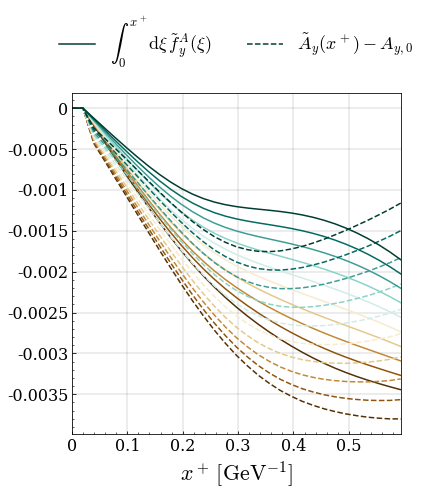

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import numpy as np  

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 7))

plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ntraj = 10

cmap_rb = mpl.cm.get_cmap('BrBG', 20)
colors = [cmap_rb(i) for i in np.linspace(0, 1, ntraj)]

i = 1
na = 8
for j in range(ntraj):
    plt.plot(xplus, da[:, j, i, na].imag, linewidth=1.5, linestyle='--', color=colors[j])
    plt.plot(xplus, intfa[:, j, i, na].imag, linewidth=1.5, color=colors[j])

plt.xlim([0, max(xplus)])
# plt.ylim([-100, 100])
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.xlabel(r"$x^+\,\mathrm{[GeV^{-1}]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color=colors[ntraj-1], lw=1.5, linestyle='-', label=r'$\int_0^{x^+}\mathrm{d}\xi\,\tilde{f}_y^A(\xi)$'),
    Line2D([0], [0], color=colors[ntraj-1], lw=1.5, linestyle='--', label=r'$\tilde{A}_y(x^+)-A_{y,0}$'),
]

legend = plt.legend(handles=legend_elements, fontsize=18, frameon=False, ncol=2, loc='lower center', bbox_to_anchor=(0.5, 1.02), title_fontsize=20)

plt.tight_layout()
# plt.savefig('intfa_deltaa_y_static_n_' + str(N) + '.png', facecolor='w', dpi=600) 
plt.show()

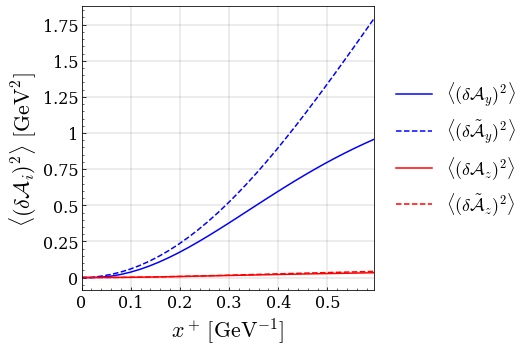

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(7.5, 5))

plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

i = 1
line1, = plt.plot(xplus, da_sq[:, i], linewidth=1.5, color='blue')
line2, = plt.plot(xplus, da_transp_sq[:, i], linewidth=1.5, color='blue', linestyle='--')

i = 2
line3, = plt.plot(xplus, da_sq[:, i], linewidth=1.5, color='red')
line4, = plt.plot(xplus, da_transp_sq[:, i], linewidth=1.5, color='red', linestyle='--')

plt.xlim([0, max(xplus)])
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

plt.xlabel(r"$x^+\,\mathrm{[GeV^{-1}]}$", fontsize=22)
plt.ylabel(r"$\langle (\delta \mathcal{A}_i)^2\rangle\,\,\mathrm{[GeV^2]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

legend2 = plt.legend([line1, line2, line3, line4], [r"$\langle (\delta \mathcal{A}_y)^2\rangle$", r"$\langle (\delta \tilde{\mathcal{A}}_y)^2\rangle$", r"$\langle (\delta \mathcal{A}_z)^2\rangle$", r"$\langle (\delta \tilde{\mathcal{A}}_z)^2\rangle$"], fontsize=18, frameon=False, ncol=1, loc='center left', bbox_to_anchor=(1.02, 0.5), title_fontsize=20)

plt.tight_layout()
# plt.tight_layout(rect=[0, 0, 0.85, 1])
# plt.savefig('delta_a_delta_atilde_static_n_' + str(N) + '.png', facecolor='w', dpi=600) 

plt.show()

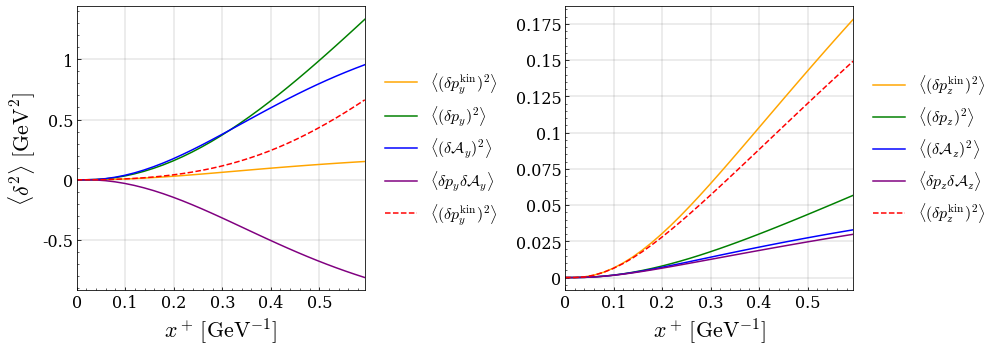

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

fig, axes = plt.subplots(1, 2, figsize=(14, 5)) 

labels = ['x', 'y', 'z']

for ax, i, title in zip(
    axes,
    [1, 2],
    [r"$i=0$", r"$i=2$"]
):
    line1, = ax.plot(xplus, dpkin_sq[:, i], linewidth=1.5, color='orange', label=rf"$\langle (\delta p^\mathrm{{kin}}_{labels[i]})^2\rangle$")
    line2, = ax.plot(xplus, dpcan_sq[:, i], linewidth=1.5, color='green', label=rf"$\langle (\delta p_{labels[i]})^2\rangle$")
    line3, = ax.plot(xplus, da_sq[:, i], linewidth=1.5, color='blue', label=rf"$\langle (\delta \mathcal{{A}}_{labels[i]})^2\rangle$")
    line4, = ax.plot(xplus, dpcanda[:, i], linewidth=1.5, color='purple', label=fr"$\langle \delta p_{labels[i]} \delta \mathcal{{A}}_{labels[i]}\rangle$")
    # convention Alatt = -igaA, so mixed term delta p * delta A is with +
    line5, = ax.plot(xplus, dpcan_sq[:, i] + da_sq[:, i] + 2 * dpcanda[:, i], linewidth=1.5, color='red', linestyle="--", label=rf"$\langle (\delta p^\mathrm{{kin}}_{labels[i]})^2\rangle$")

    ax.set_xlim([0, max(xplus)])
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    ax.set_xlabel(r"$x^+\,\mathrm{[GeV^{-1}]}$", fontsize=22)
    ax.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)
    ax.tick_params(axis='both', which='major', direction='in')
    ax.minorticks_on()
    ax.tick_params(axis='both', which='minor', direction='in')
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    handles = [line1, line2, line3, line4, line5]
    labels_ = [h.get_label() for h in handles]

    ax.legend(handles, labels_, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=16, frameon=False, ncol=1)

axes[0].set_ylabel(r"$\langle \delta^2\rangle\,\,\mathrm{[GeV^2]}$", fontsize=22)

# plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.tight_layout()
# plt.savefig('delta_sq_delta_a_static_n_' + str(N) + '.png', facecolor='w', dpi=600) 

plt.show()


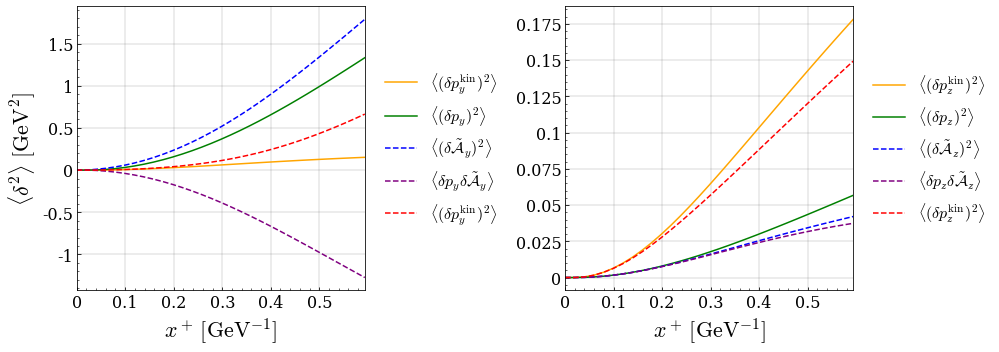

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

fig, axes = plt.subplots(1, 2, figsize=(14, 5)) 

labels = ['x', 'y', 'z']

for ax, i, title in zip(
    axes,
    [1, 2],
    [r"$i=0$", r"$i=2$"]
):
    line1, = ax.plot(xplus, dpkin_sq[:, i], linewidth=1.5, color='orange', label=rf"$\langle (\delta p^\mathrm{{kin}}_{labels[i]})^2\rangle$")
    line2, = ax.plot(xplus, dpcan_sq[:, i], linewidth=1.5, color='green', label=rf"$\langle (\delta p_{labels[i]})^2\rangle$")
    line3, = ax.plot(xplus, da_transp_sq[:, i], linewidth=1.5, color='blue', label=rf"$\langle (\delta \tilde{{\mathcal{{A}}}}_{labels[i]})^2\rangle$", linestyle='--')
    line4, = ax.plot(xplus, dpcanda_transp[:, i], linewidth=1.5, color='purple', label=fr"$\langle \delta p_{labels[i]} \delta \tilde{{\mathcal{{A}}}}_{labels[i]}\rangle$", linestyle='--')
    line5, = ax.plot(xplus, dpcan_sq[:, i] + da_sq[:, i] + 2 * dpcanda[:, i], linewidth=1.5, color='red', label=rf"$\langle (\delta p^\mathrm{{kin}}_{labels[i]})^2\rangle$", linestyle='--')

    ax.set_xlim([0, max(xplus)])
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    ax.set_xlabel(r"$x^+\,\mathrm{[GeV^{-1}]}$", fontsize=22)
    ax.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)
    ax.tick_params(axis='both', which='major', direction='in')
    ax.minorticks_on()
    ax.tick_params(axis='both', which='minor', direction='in')
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    handles = [line1, line2, line3, line4, line5]
    labels_ = [h.get_label() for h in handles]

    ax.legend(handles, labels_, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=16, frameon=False, ncol=1)

axes[0].set_ylabel(r"$\langle \delta^2\rangle\,\,\mathrm{[GeV^2]}$", fontsize=22)

plt.tight_layout()
# plt.savefig('delta_sq_delta_atilde_static_n_' + str(N) + '.png', facecolor='w', dpi=600) 

plt.show()
